# Making stacked histograms
- processes an `events[year][ch][sample]` object using `make_events_dict()`
- uses `plot_hists()` to make stacked histograms

In [321]:
import glob
import os
import json
import pickle
import pickle as pkl
import yaml
import math

import numpy as np
import pandas as pd
pd.options.mode.chained_assignment = None
import pyarrow.parquet as pq
from sklearn.metrics import auc, roc_curve
from scipy.special import softmax

import hist as hist2
import matplotlib.pyplot as plt
import mplhep as hep

plt.style.use(hep.style.CMS)

import sys
sys.path.append("../python/")

import utils

plt.rcParams.update({"font.size": 20})

In [322]:
%load_ext autoreload
%autoreload 2
%reload_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [323]:
# get lumi
with open("../fileset/luminosity.json") as f:
    luminosity = json.load(f)
    
luminosity

{'ele': {'Run2': 137640.0,
  '2016APV': 19492.72,
  '2016': 16809.96,
  '2017': 41476.02,
  '2018': 59816.23},
 'mu': {'Run2': 137640.0,
  '2016APV': 19436.16,
  '2016': 16810.81,
  '2017': 41475.26,
  '2018': 59781.96},
 'lep': {'Run2': 137640.0,
  '2016APV': 19436.16,
  '2016': 16810.81,
  '2017': 41475.26,
  '2018': 59781.96},
 'had': {'Run2': 137640.0,
  '2016APV': 19436.16,
  '2016': 16810.81,
  '2017': 41475.26,
  '2018': 59781.96}}

In [324]:
def get_lumi(years, channels):
    lum_ = 0
    for year in years:
        lum = 0
        for ch in channels:
            lum += luminosity[ch][year] / 1000.0

        lum_ += lum / len(channels)    
    return lum_

In [325]:
 # define your regions here
presel = {
        "mu": {
            "lepmiso": "(lep_pt<55) | ( (lep_pt>=55) & (lep_misolation<0.8) )",   # needed for the fakes            
#             "preselection": "(fj_mass>40)",
            "preselection + tagger": "(fj_mass>40) & (THWW>0.75)",
#             "FakeValidation": "fj_mass>30 & fj_mass<40",
        },
        "ele": {
#             "preselection": "(fj_mass>40)",
            "preselection + tagger": "(fj_mass>40) & (THWW>0.75)",
#             "FakeValidation": "fj_mass>30 & fj_mass<40",
        },
}

channels = [
    "ele",
    "mu",
]
samples = [
    "ggF", 
    "VBF",  
    "WH",
    "ZH",
    "ttH",
    
#     "QCD",
    "WJetsLNu",
    "TTbar",
    "SingleTop",
    "Diboson",
    "EWKvjets",
    "DYJets",
    "WZQQ",

    "Data",
#     "Fake",
]

years = [
#     "2016",
#     "2016APV",
    "2017",
#     "2018",
]

In [326]:
samples_dir = {
    "2016":    "../eos/hww/Dec20_hww_2016",
    "2016APV": "../eos/hww/Dec20_hww_2016APV",
    "2017":    "../eos/hww/Dec20_hww_2017",
#     "2017":    "../eos/hww/Jun5_hww_2017",

    "2018":    "../eos/hww/Dec20_hww_2018",
}

THWW_path = "../../weaver-core-dev/experiments_finetuning/v35_30/model.onnx"

from make_stacked_hists import make_events_dict

events_dict = make_events_dict(years, channels, samples_dir, samples, presel, THWW_path, fake_SF={"ele": 0.75, "mu": 1})

INFO:root:Processing 2017 ele channel
INFO:root:Processing 2017 mu channel


# Stacked hists

In [334]:
with open("../combine/trg_eff_SF_ARC.pkl", "rb") as f:
    TRIGGER_SF = pickle.load(f)

In [336]:
def fix_neg_yields(h):
    """
    Will set the bin yields of a process to 0 if the nominal yield is negative, and will
    set the yield to 0 for the full Systematic axis.
    """
    for sample in h.axes["samples"]:
        neg_bins = np.where(h[{"samples": sample}].values() < 0)[0]

        if len(neg_bins) > 0:
            print(f"{sample}, has {len(neg_bins)} bins with negative yield.. will set them to 0")

            sample_index = np.argmax(np.array(h.axes["samples"]) == sample)

            for neg_bin in neg_bins:
                h.view(flow=True)[sample_index, neg_bin + 1] = (0, 0)           

In [329]:
from syst_unc_utils import (
    fill_syst_unc_hists,
    get_total_syst_unc,
    initialize_syst_unc_hists,
)

vars_to_plot = [
    
#     "dR_genlep_recolep", 
        ############# AN start
#         "FirstFatjet_pt",
#         "fj_lsf3",
#         "fj_mass",
#         "fj_ParT_mass",
#         "fj_pt",
#         "ht",
#         "lep_fj_dr",  
#         "lep_isolation_ele_highpt",
#         "lep_isolation_ele_lowpt",
#         "lep_isolation_mu_highpt",
#         "lep_isolation_mu_lowpt",
#         "lep_met_mt",
#         "lep_misolation_ele_highpt",
#         "lep_misolation_ele_lowpt",
#         "lep_misolation_mu_highpt",
#         "lep_misolation_mu_lowpt",
#         "lep_pt",
#         "lep_eta",
#         "met_fj_dphi",
#         "met_pt",
#         "NumFatjets",
#         "NumOtherJets",
#         "rec_higgs_m",
#         "rec_W_lnu_m",
#         "rec_W_qq_m",
#         "SecondFatjet_pt",
#         "met_phi",    
#         "THWW",
        ############## AN end

        ############## Fake vs QCD
#         "fj_pt",
#         "lep_pt",
#         "met_pt",
#         "lep_fj_dr",
#         "THWW",
    
        ############## Control regions
        "fj_pt",
        "lep_pt",
        "lep_fj_dr",
        "met_pt",
        "rec_higgs_m",

        ############## Fake validation region
#         "fj_pt",
#         "lep_pt",
#         "lep_eta",
#         "met_pt",
    
        # more
#         "fj_lsf3",
#         "rec_higgs_m",
#         "fj_mass",
    #     "fj_ParT_mass",
#         "fj_pt",
    #     "lep_fj_dr",
    #     "met_pt",
    #     "rec_W_lnu_m",
    #     "rec_W_qq_m",
    #     "met_phi",
#         "rec_higgs_pt",
#         "lep_eta",
#     "rho",
#     "pt_ratio",
#     "mjj",  
#     "deta",
#     "fj_VScore",
#     "SecondFatjet_Vscore",
]

samples_to_plot = [
        "ggF",
        "VBF",
        "ttH",
        "WH",
        "ZH",
#         "Fake",
        "SingleTop",
        "DYJets",
        "WZQQ",    
        "Diboson",
        "EWKvjets",
        "TTbar",
        "WJetsLNu",
#         "WJetsLNu_LO",    
        "Data",
    
#     "QCD",
    
#     "TTbar_is_top_lq",
#     "TTbar_is_top_lqq",
#     "TTbar_others",
    
#     "WJetsLNu_unmatched",
#     "WJetsLNu_matched",
]


years_to_plot = [
#     "2016",
#     "2016APV",
    "2017",
#     "2018",
]

channels_to_plot = [
        "ele",
        "mu",
]

plot_syst_unc = False
massbin = 5

if plot_syst_unc:
    import sys

    sys.path.append("../combine/")
    from systematics import get_systematic_dict

    SYST_DICT = get_systematic_dict(years_to_plot)
    
    SYST_UNC_up, SYST_UNC_down = {}, {}
    SYST_hists = initialize_syst_unc_hists(SYST_DICT, {"years_to_plot": years_to_plot, "vars_to_plot": vars_to_plot, "massbin": massbin})  

In [332]:
WP_ggF = 0.93
WP_VBF = 0.905

region_sel = {
    "Pre-selection": "(fj_mass>40) & (THWW>0.75)",   # dummy
#     "Fake validation": "fj_mass>30 & fj_mass<40",
#     "SR": f"THWW>{WP_VBF} & (n_bjets_T==0)",
#     "Top CR": f"(n_bjets_T>0) & THWW>0.9",
#     "WJets CR": f"(n_bjets_T==0) & (THWW<0.905) & (rec_higgs_pt>250) & (NumFatjets>=2)",
}
region, sel = list(region_sel.items())[0]

shift = 50
categories_sel = {
#     "VBF category": f"( (THWW>{WP_VBF}) & (n_bjets_T==0) ) & ( (mjj>1000) & (deta>3.5) )",

#     "ggF category": f"( (THWW>{WP_ggF}) & (n_bjets_T==0) ) & ( ( (mjj<1000) | (deta<3.5) ) ) & (VH_fj_VScore<0.9)",    
    
#     r"ggF $p_T \in $ " + f"[{200+shift}, {300+shift}]": f"( (THWW>{WP_ggF}) & (n_bjets_T==0) ) & ( ( (mjj<1000) | (deta<3.5) ) & (rec_higgs_pt<{300+shift}) ) & (VH_fj_VScore<0.9)",
#     r"ggF $p_T \in $ " + f"[{300+shift}, {450+shift}]": f"( (THWW>{WP_ggF}) & (n_bjets_T==0) ) & ( ( (mjj<1000) | (deta<3.5) ) & (rec_higgs_pt>{300+shift}) & (rec_higgs_pt<{450+shift}) ) & (VH_fj_VScore<0.9)",
#     r"ggF $p_T \in $ " + f"[{450+shift}, Inf]": f"( (THWW>{WP_ggF}) & (n_bjets_T==0) ) & ( ( (mjj<1000) | (deta<3.5) ) & (rec_higgs_pt>{450+shift}) ) & (VH_fj_VScore<0.9)",      
}

num, den = 0, 0
threshold = 0

# fill histograms
import utils
from utils import get_axis

# instantiate nominal histograms
hists = {}
for var_to_plot in vars_to_plot:
    
    hists[var_to_plot] = hist2.Hist(
        hist2.axis.StrCategory([], name="samples", growth=True),
        utils.get_axis(var_to_plot,massbin),
        storage=hist2.storage.Weight(),
    )

# start filling the histograms
for var_to_plot in vars_to_plot:    
    for year in years_to_plot:
        for ch in channels_to_plot:
            for sample in samples_to_plot:   

#                 # -------------- some samples may be split during plotting to matched/unmatched
#                 if "TTbar" in sample:
                    
#                     if "TTbar_LP" in sample:
#                         df = pd.read_parquet(f"../LP/LP_TTbar_{year}_{ch}.parquet")
#                         df["nominal"] = df["LP_weight_nom"]
#                     else:
#                         df = pd.read_parquet(f"../LP/LP_TTbar_{year}_{ch}.parquet")           
                    
                    # TODO
#                     df = events_dict[year][ch]["TTbar"]

#                     ########## seperate topologies by color                    
#                     is_top_lq = (df["fj_Top_nquarksnob"]==1) & (df["fj_Top_nbquarks"]==0)                        
#                     is_top_lqq = (df["fj_Top_nquarksnob"]==2) & (df["fj_Top_nbquarks"]==0)

#                     if (sample == "TTbar_is_top_lq"):
#                         df = df[is_top_lq]
#                     elif (sample == "TTbar_is_top_lqq"):
#                         df = df[is_top_lqq]
#                     elif (sample == "TTbar_others"):
#                         df = df[~(is_top_lq | is_top_lqq)]

                df = events_dict[year][ch][sample]
                df = df.query(sel)
                                     
                if len(categories_sel)>=1:
                    category, category_sel = list(categories_sel.items())[0]
                    df = df.query(category_sel)
            

                # ----------- some variables need manual tweaking
                if "lep_isolation_ele" in var_to_plot:
                    if ch != "ele":
                        continue
                    df = df[(df["lep_pt"] > 120)] if "highpt" in var_to_plot else df[(df["lep_pt"] < 120)]
                    df[var_to_plot] = df["lep_isolation"]

                elif "lep_isolation_mu" in var_to_plot:
                    if ch != "mu":
                        continue
                    df = df[(df["lep_pt"] > 55)] if "highpt" in var_to_plot else df[(df["lep_pt"] < 55)]
                    df[var_to_plot] = df["lep_isolation"]

                elif "lep_misolation_ele" in var_to_plot:
                    if ch != "ele":
                        continue
                    df = df[(df["lep_pt"] > 120)] if "highpt" in var_to_plot else df[(df["lep_pt"] < 120)]
                    df[var_to_plot] = df["lep_misolation"]

                elif "lep_misolation_mu" in var_to_plot:
                    if ch != "mu":
                        continue
                    df = df[(df["lep_pt"] > 55)] if "highpt" in var_to_plot else df[(df["lep_pt"] < 55)]
                    df[var_to_plot] = df["lep_misolation"]

                
                # ----------- done with the above.  
                add_TRG_SF = True
                if (add_TRG_SF) and (sample != "Data") and (ch == "ele"):
                    ptbinning = [2000, 200, 170, 150, 130, 110, 90, 70, 50, 30]
                    etabinning = [-2.5, -1.5, -0.5,  0.5,  1.5,  2.5]

                    for i in range(len(ptbinning)-1):
                        high_pt = ptbinning[i]
                        low_pt = ptbinning[i+1]

                        msk_pt = (df["lep_pt"] >= low_pt) & (df["lep_pt"] < high_pt)

                        for j in range(len(etabinning)-1):
                            low_eta = etabinning[j]
                            high_eta = etabinning[j+1]

                            msk_eta = (abs(df["lep_eta"]) >= low_eta) & (abs(df["lep_eta"]) < high_eta)

                            df["nominal"][msk_pt & msk_eta] *= TRIGGER_SF["UL" + year[2:].replace("APV", "")]["nominal"][i,j]


                hists[var_to_plot].fill(
                    samples=sample,
                    var=df[var_to_plot],
                    weight=df["nominal"],
                )

                if plot_syst_unc:
                    SYST_hists_sig = fill_syst_unc_hists(SYST_DICT, SYST_hists, year, ch, sample, var_to_plot, df)

    fix_neg_yields(hists[var_to_plot])
    
    if plot_syst_unc:
        SYST_UNC_up[var_to_plot], SYST_UNC_down[var_to_plot] = get_total_syst_unc(
            SYST_hists[var_to_plot]
        )
        
        sys_keys = ["sys", "prongs", "unclust", "distortion"]
        for sys_key in sys_keys:
            up = SYST_hists_sig[var_to_plot]["up"][f"LP_weight_{sys_key}"].values()
            down = SYST_hists_sig[var_to_plot]["down"][f"LP_weight_{sys_key}"].values()

            SYST_hists[var_to_plot]["up"][f"LP_weight_{sys_key}"].view().value = np.maximum(up, down)
            SYST_hists[var_to_plot]["down"][f"LP_weight_{sys_key}"].view().value = np.minimum(up, down)

[autoreload of utils failed: Traceback (most recent call last):
  File "/Users/fmokhtar/miniconda3/envs/coffea-env/lib/python3.9/site-packages/IPython/extensions/autoreload.py", line 276, in check
    superreload(m, reload, self.old_objects)
  File "/Users/fmokhtar/miniconda3/envs/coffea-env/lib/python3.9/site-packages/IPython/extensions/autoreload.py", line 475, in superreload
    module = reload(module)
  File "/Users/fmokhtar/miniconda3/envs/coffea-env/lib/python3.9/importlib/__init__.py", line 169, in reload
    _bootstrap._exec(spec, module)
  File "<frozen importlib._bootstrap>", line 613, in _exec
  File "<frozen importlib._bootstrap_external>", line 786, in exec_module
  File "<frozen importlib._bootstrap_external>", line 923, in get_code
  File "<frozen importlib._bootstrap_external>", line 853, in source_to_code
  File "<frozen importlib._bootstrap>", line 228, in _call_with_frames_removed
  File "../python/utils.py", line 401
    return axis_dict[var]
    ^
SyntaxError: inva

DYJets, has 1 bins with negative yield.. will set them to 0
SingleTop, has 2 bins with negative yield.. will set them to 0


Will plot fj_pt histogram
#bins: 30, chi_square: 182.294, reduced_chi_square: 6.286
Will plot lep_pt histogram
#bins: 20, chi_square: nan, reduced_chi_square: nan


../python/utils.py:647: RuntimeWarning: invalid value encountered in divide
  rax.axhline(1, ls="--", color="k")


Will plot lep_fj_dr histogram
#bins: 35, chi_square: 228.707, reduced_chi_square: 6.727
Will plot met_pt histogram
#bins: 40, chi_square: 260.465, reduced_chi_square: 6.679
Will plot rec_higgs_m histogram
#bins: 35, chi_square: 145.566, reduced_chi_square: 4.281


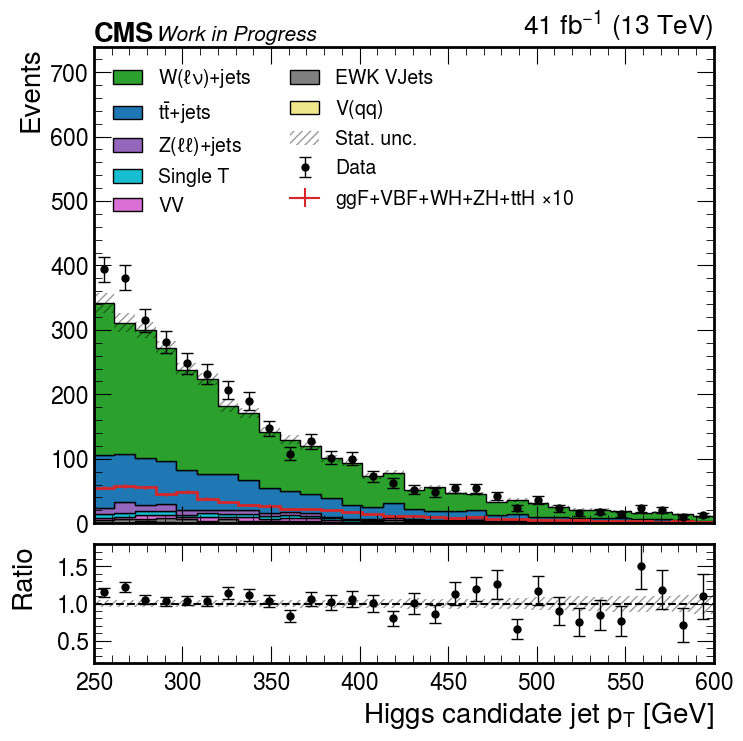

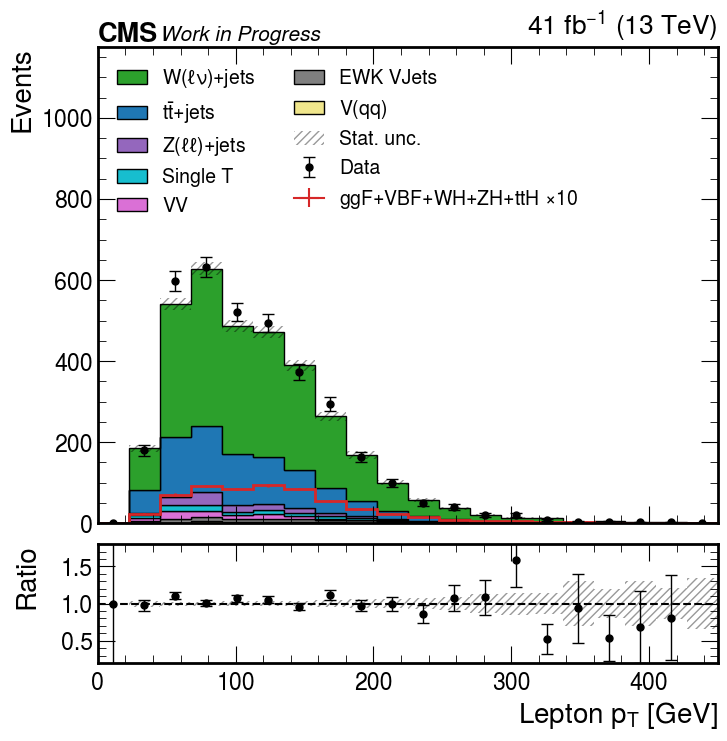

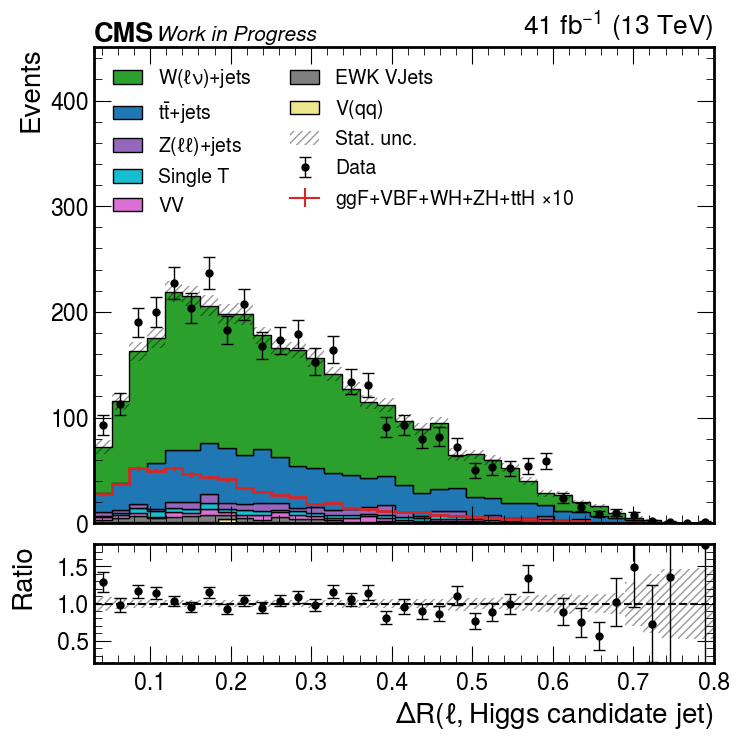

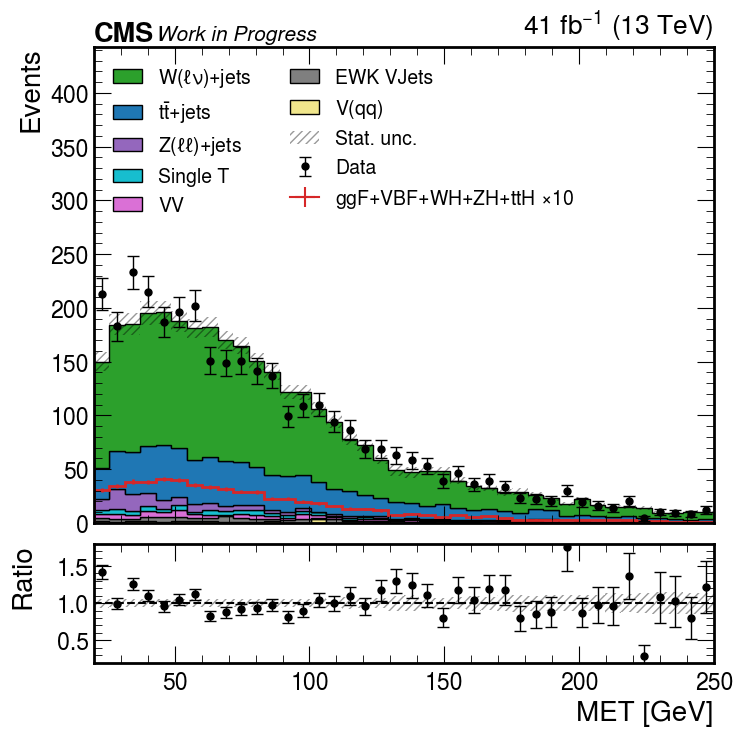

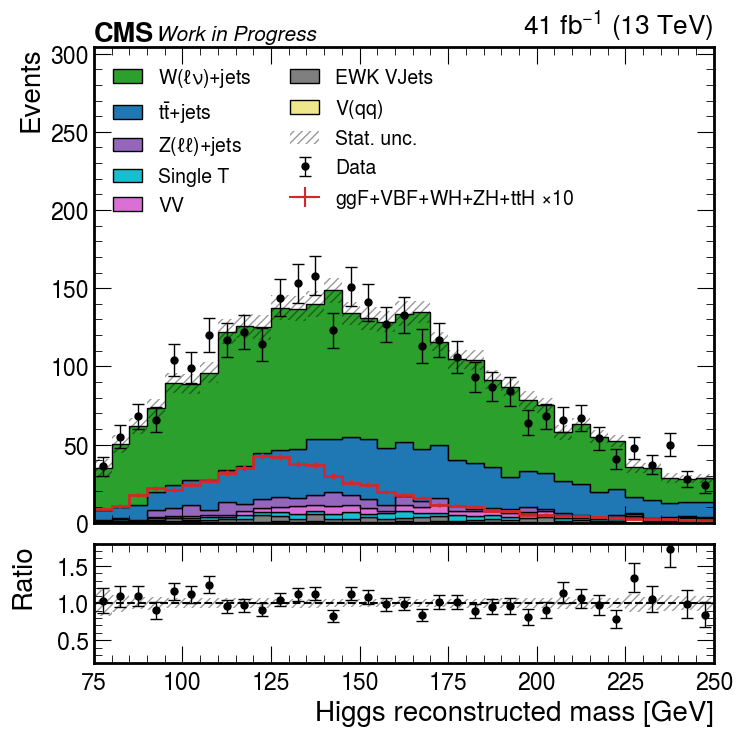

In [333]:
plt.rcParams.update({"font.size": 20})
add_data = True

if "SR" in region or ("Signal region") in region:
    blind_region=[90,160]
    mult = 10
else:
    blind_region=False
    mult = 1

if "VBF category" in categories_sel:
    mult = 5


from utils import plot_hists as plot_hists
# PATH = f"/Users/fmokhtar/Desktop/AN_2024/ARC/eletriggerSF/with_trgSF/"
PATH = f"/Users/fmokhtar/Desktop/AN_2024/ARC/WJetsCR_LO/Run2/"

# PATH = f"/Users/fmokhtar/Desktop/AN_2024/lol"


if not os.path.exists(PATH):
    os.makedirs(PATH)    

nice_ch = {
    "ele": "Electron",
    "mu": "Muon",
}

plot_hists(hists, years_to_plot, channels_to_plot, vars_to_plot,
            add_data=True,
            logy=False,
            mult=10,
            outpath=PATH,
#             text_=f"{nice_ch[ch]} channel",
#             text_=list(region_sel.items())[0][0],
#             text_=list(region_sel.items())[0][0] + " (w/o Nick and EWK corr)",
#             text_=list(region_sel.items())[0][0] + " (w/ k-factor applied)",
#             text_=list(categories_sel.items())[0][0] + " (w/ k-factor applied)",
            blind_region=blind_region,
            plot_Fake_unc=0.25,
            plot_syst_unc=(SYST_UNC_up, SYST_UNC_down) if plot_syst_unc else None,
           add_soverb=False,
           legend_ncol=2,
#            seperate_Fake_unc=True,
           plot_totsig=True,
           plot_sig_components=False,
          )

# Make yield composition table

In [ ]:
def make_composition_table(ev, presel, add_soverb=False, use_Fake=False):

    from collections import OrderedDict
    
    all_MCsamples = [
        "ggF", 
        "VBF",
        "ttH",
        "WH",
        "ZH",        
        "WJetsLNu",
        "TTbar",
        "SingleTop",
        "Diboson",
        "EWKvjets",
        "DYJets",
        "WZQQ",
    ]
    if use_Fake:    
        all_MCsamples += ["Fake"]
        bkg = ["TTbar", "WJetsLNu", "Fake", "Others"]        
    else:
        all_MCsamples += ["QCD"]
        bkg = ["TTbar", "WJetsLNu", "QCD", "Others"]        
    
    sig = ["VBF", "ggF", "WH", "ZH", "ttH"]

    mass_window = [50, 150]
    
    # make table
    print("\\begin{table}[!ht]")
    print("\\begin{center}")
    
    if add_soverb:
        print("\\caption{Event yield contribution from different processes in the search regions for the full Run2 dataset. The last column includes $s/\sqrt{b}$ in a mass window of 100-150\GeV in the mass observable (the Higgs reconstructed mass).}")
    else:
        print("\\caption{Event yield contribution from different processes in the search regions for the full Run2 dataset.}")
        
    if add_soverb:
        print("\\begin{tabular}{c|ccccc|cccc|c}")
    else:
        print("\\begin{tabular}{c|ccccc|cccc}")

    if add_soverb:    
        print("& \\multicolumn{5}{c|}{Signal yield} & \\multicolumn{4}{c|}{Background yield} & \\multicolumn{1}{c}{$s/\sqrt{b}$} \\\\\n")
        if use_Fake:
            print("& VBF & ggF & WH & ZH & \\ttH & \\ttbar & W$+$jets & Fake & Other & \\\\\n")
        else:
            print("& VBF & ggF & WH & ZH & \\ttH & \\ttbar & W$+$jets & QCD & Other & \\\\\n")
    else:
        print("& \\multicolumn{5}{c|}{Signal yield} & \\multicolumn{4}{c}{Background yield} \\\\\n")
        if use_Fake:        
            print("& VBF & ggF & WH & ZH & \\ttH & \\ttbar & W$+$jets & Fake & Other \\\\\n")
        else:
            print("& VBF & ggF & WH & ZH & \\ttH & \\ttbar & W$+$jets & QCD & Other \\\\\n")
            
    print("\\hline")
    print("\\hline")

    years_to_cover = years
    for region, sel in presel.items():
        if sel == 0:
            print("\\hline")
            continue
            
        if "2018" in region:
            years_to_cover = ["2018"]
        elif "2017" in region:
            years_to_cover = ["2017"]
        elif "2017" in region:
            years_to_cover = ["2017"]
        elif "2016APV" in region:
            years_to_cover = ["2016APV"]
        elif "2016" in region:
            years_to_cover = ["2016"]
        else:
            years_to_cover = years
        
        sig_dict = OrderedDict({
            "VBF": 0,
            "ggF": 0,
            "WH": 0,
            "ZH": 0,
            "ttH": 0,            
        })

        if use_Fake:           
            bkg_dict = OrderedDict({
                "TTbar": 0,
                "WJetsLNu": 0, 
                "Fake": 0,
                "Others": 0,    
            })
        else:
            bkg_dict = OrderedDict({
                "TTbar": 0,
                "WJetsLNu": 0, 
                "QCD": 0,
                "Others": 0,    
            })            

        tot_sig, tot_bkg = 0, 0
        s, b = 0, 0   # in mass window [100, 150]
        for year in years_to_cover:
            for ch in channels:
                for sample in all_MCsamples:
                    
                    df = ev[year][ch][sample]

                    df = df.query(sel)  

                    if sample in sig_dict:
                        tot_sig += df["nominal"].sum()                    
                        sig_dict[sample] += df["nominal"].sum()
                    elif sample in bkg_dict:
                        tot_bkg += df["nominal"].sum()
                        bkg_dict[sample] += df["nominal"].sum()
                    else:
                        tot_bkg += df["nominal"].sum()                        
                        bkg_dict["Others"] += df["nominal"].sum()                    

                    ######################## soverb start
                    df = df[(df["rec_higgs_m"]>=mass_window[0]) & (df["rec_higgs_m"]<=mass_window[1])]

                    if sample in sig_dict:                
                        s += df["nominal"].sum()
                    else:
                        b += df["nominal"].sum()
                    ######################## soverb end

        texdata = "\multirow{2}{*}{" + region + "} & \multicolumn{5}{c|}{"
        texdata += str(round(tot_sig))
        
        if add_soverb:
            texdata += "} & \multicolumn{4}{c|}{"
            texdata += str(round(tot_bkg))
            texdata += "} & \multicolumn{1}{c}{"            
#             texdata += str(round(s/(b**0.5),3))
            texdata += "\multirow{2}{*}{" + str(round(s/(b**0.5),3)) + "}"
            
            texdata += "} \\\\\n"
        else:
            texdata += "} & \multicolumn{4}{c}{"
            texdata += str(round(tot_bkg))
            texdata += "} \\\\\n"
        
#         texdata += "\\cline{2-9} \n"
        
        for sample in sig_dict:
            texdata += f" & {(100*sig_dict[sample]/tot_sig):.0f}\%"
#             texdata += f" & {(sig_dict[sample]):.2f}"
            
        for sample in bkg_dict:
            if bkg_dict[sample]<0:
                bkg_dict[sample]=0
            texdata += f" & {(100*bkg_dict[sample]/tot_bkg):.0f}\%"
#             texdata += f" & {(bkg_dict[sample]):.2f}"            
        
        if add_soverb:
            texdata += " & "

        texdata += " \\\\\n"
        print(texdata)
        print("\\hline")

    print("\\hline")
    print("\\end{tabular}")
    print("\\label{tab:}")
    print("\\end{center}")
    print("\\end{table}")      

In [19]:
shift = 50
WP_VBF = 0.905
WP_ggF = 0.93

presel = {
#     "Pre-selection": f"THWW>0", # dummy    
    
#     "Top CR": f"n_bjets_T>0", # dummy
    
#     "bveto": f"n_bjets_T==0", # dummy

    
#     "Signal region": f"(THWW>0.92) & (n_bjets_T==0)",    
#     "Top control region": f"(THWW>0.75) & (n_bjets_T>0)",
#     "W+Jets control region": f"(THWW<0.905) & (THWW>0.75) & (n_bjets_T==0)",

#     "VBF category": f"( (THWW>{WP_VBF}) & (n_bjets_T==0) ) & ( (mjj>1000) & (deta>3.5) & (NumOtherJets>=2) )",
    
#     r"ggF category $p_T \in $ " + f"[{200+shift}, {300+shift}]": f"( (THWW>{WP_ggF}) & (n_bjets_T==0) ) & ( ( (mjj<1000) | (deta<3.5) | (NumOtherJets<2) ) & (rec_higgs_pt<{300+shift}) ) & (VH_fj_VScore<0.9)",
#     r"ggF category $p_T \in $ " + f"[{300+shift}, {450+shift}]": f"( (THWW>{WP_ggF}) & (n_bjets_T==0) ) & ( ( (mjj<1000) | (deta<3.5) | (NumOtherJets<2) ) & (rec_higgs_pt>{300+shift}) & (rec_higgs_pt<{450+shift}) ) & (VH_fj_VScore<0.9)",
#     r"ggF category $p_T \in $ " + f"[{450+shift}, Inf]": f"( (THWW>{WP_ggF}) & (n_bjets_T==0) ) & ( ( (mjj<1000) | (deta<3.5) | (NumOtherJets<2) ) & (rec_higgs_pt>{450+shift}) ) & (VH_fj_VScore<0.9)",      
    

    "Top control region (RUN2)": f"(THWW>0.9) & (n_bjets_T>0)",
    "Top control region (2018)": f"(THWW>0.9) & (n_bjets_T>0)",
    "Top control region (2017)": f"(THWW>0.9) & (n_bjets_T>0)",
    "Top control region (2016)": f"(THWW>0.9) & (n_bjets_T>0)",
    "Top control region (2016APV)": f"(THWW>0.9) & (n_bjets_T>0)",
    
#     "W+Jets control region (RUN2)": f"(THWW<0.90) & (THWW>0.75) & (n_bjets_T==0)",
#     "W+Jets control region (2018)": f"(THWW<0.90) & (THWW>0.75) & (n_bjets_T==0)",
#     "W+Jets control region (2017)": f"(THWW<0.90) & (THWW>0.75) & (n_bjets_T==0)",
#     "W+Jets control region (2016)": f"(THWW<0.90) & (THWW>0.75) & (n_bjets_T==0)",
#     "W+Jets control region (2016APV)": f"(THWW<0.90) & (THWW>0.75) & (n_bjets_T==0)",
}

make_composition_table(events_dict, presel, add_soverb=False, use_Fake=True)

\begin{table}[!ht]
\begin{center}
\caption{Event yield contribution from different processes in the search regions for the full Run2 dataset.}
\begin{tabular}{c|ccccc|cccc}
& \multicolumn{5}{c|}{Signal yield} & \multicolumn{4}{c}{Background yield} \\

& VBF & ggF & WH & ZH & \ttH & \ttbar & W$+$jets & Fake & Other \\

\hline
\hline
\multirow{2}{*}{Top control region (RUN2)} & \multicolumn{5}{c|}{9} & \multicolumn{4}{c}{452} \\
 & 7\% & 27\% & 3\% & 11\% & 51\% & 79\% & 12\% & 0\% & 11\% \\

\hline
\multirow{2}{*}{Top control region (2018)} & \multicolumn{5}{c|}{4} & \multicolumn{4}{c}{204} \\
 & 6\% & 26\% & 3\% & 11\% & 54\% & 80\% & 11\% & 0\% & 10\% \\

\hline
\multirow{2}{*}{Top control region (2017)} & \multicolumn{5}{c|}{2} & \multicolumn{4}{c}{138} \\
 & 5\% & 28\% & 4\% & 12\% & 51\% & 78\% & 11\% & 0\% & 13\% \\

\hline
\multirow{2}{*}{Top control region (2016)} & \multicolumn{5}{c|}{1} & \multicolumn{4}{c}{47} \\
 & 9\% & 27\% & 5\% & 11\% & 48\% & 79\% & 11\% & 0\% & 12\% \\

In [80]:
# this one skips the Fake altogether (relevant to signal region)

def make_composition_table(ev, presel, add_soverb=False):

    from collections import OrderedDict
    
    all_MCsamples = [
        "ggF", 
        "VBF",
        "ttH",
        "WH",
        "ZH",        
        "WJetsLNu",
        "TTbar",
        "SingleTop",
        "Diboson",
        "EWKvjets",
        "DYJets",
        "WZQQ",
    ]
    
    bkg = ["TTbar", "WJetsLNu", "Others"]
    sig = ["VBF", "ggF", "WH", "ZH", "ttH"]

    mass_window = [50, 150]
    
    # make table
    print("\\begin{table}[!ht]")
    print("\\begin{center}")
    
    if add_soverb:
        print("\\caption{Event yield contribution from different processes in the search regions for the full Run2 dataset. The last column includes $s/\sqrt{b}$ in a mass window of 100-150\GeV in the mass observable (the Higgs reconstructed mass).}")
    else:
        print("\\caption{Event yield contribution from different processes in the search regions for the full Run2 dataset.}")
        
    if add_soverb:
        print("\\begin{tabular}{c|ccccc|ccc|c}")
    else:
        print("\\begin{tabular}{c|ccccc|ccc}")

    if add_soverb:    
        print("& \\multicolumn{5}{c|}{Signal yield} & \\multicolumn{3}{c|}{Background yield} & \\multicolumn{1}{c}{$s/\sqrt{b}$} \\\\\n")
        print("& VBF & ggF & WH & ZH & \\ttH & \\ttbar & W$+$jets & Other & \\\\\n")
    else:
        print("& \\multicolumn{5}{c|}{Signal yield} & \\multicolumn{3}{c}{Background yield} \\\\\n")
        print("& VBF & ggF & WH & ZH & \\ttH & \\ttbar & W$+$jets & Other \\\\\n")
            
    print("\\hline")
    print("\\hline")

    years_to_cover = years
    for region, sel in presel.items():
        if sel == 0:
            print("\\hline")
            continue
            
        if "2018" in region:
            years_to_cover = ["2018"]
        elif "2017" in region:
            years_to_cover = ["2017"]
        elif "2017" in region:
            years_to_cover = ["2017"]
        elif "2016APV" in region:
            years_to_cover = ["2016APV"]
        elif "2016" in region:
            years_to_cover = ["2016"]
        else:
            years_to_cover = years
        
        sig_dict = OrderedDict({
            "VBF": 0,
            "ggF": 0,
            "WH": 0,
            "ZH": 0,
            "ttH": 0,            
        })
    
        bkg_dict = OrderedDict({
            "TTbar": 0,
            "WJetsLNu": 0, 
            "Others": 0,    
        })  

        tot_sig, tot_bkg = 0, 0
        s, b = 0, 0   # in mass window [100, 150]
        for year in years_to_cover:
            for ch in channels:
                for sample in all_MCsamples:
                    
                    df = ev[year][ch][sample]

                    df = df.query(sel)  

                    if sample in sig_dict:
                        tot_sig += df["nominal"].sum()                    
                        sig_dict[sample] += df["nominal"].sum()
                    elif sample in bkg_dict:
                        tot_bkg += df["nominal"].sum()
                        bkg_dict[sample] += df["nominal"].sum()
                    else:
                        tot_bkg += df["nominal"].sum()                        
                        bkg_dict["Others"] += df["nominal"].sum()                    

                    ######################## soverb start
                    df = df[(df["rec_higgs_m"]>=mass_window[0]) & (df["rec_higgs_m"]<=mass_window[1])]

                    if sample in sig_dict:                
                        s += df["nominal"].sum()
                    else:
                        b += df["nominal"].sum()
                    ######################## soverb end

        texdata = "\multirow{2}{*}{" + region + "} & \multicolumn{5}{c|}{"
        texdata += str(round(tot_sig))
        
        if add_soverb:
            texdata += "} & \multicolumn{3}{c|}{"
            texdata += str(round(tot_bkg))
            texdata += "} & \multicolumn{1}{c}{"            
#             texdata += str(round(s/(b**0.5),3))
            texdata += "\multirow{2}{*}{" + str(round(s/(b**0.5),3)) + "}"
            
            texdata += "} \\\\\n"
        else:
            texdata += "} & \multicolumn{3}{c}{"
            texdata += str(round(tot_bkg))
            texdata += "} \\\\\n"
        
#         texdata += "\\cline{2-9} \n"
        
        for sample in sig_dict:
#             texdata += f" & {(100*sig_dict[sample]/tot_sig):.0f}\%"
            texdata += f" & {(sig_dict[sample]):.2f}"

        
        for sample in bkg_dict:
            if bkg_dict[sample]<0:
                bkg_dict[sample]=0
#             texdata += f" & {(100*bkg_dict[sample]/tot_bkg):.0f}\%"
            texdata += f" & {(bkg_dict[sample]):.2f}"            
        
        if add_soverb:
            texdata += " & "

        texdata += " \\\\\n"
        print(texdata)
        print("\\hline")

    print("\\hline")
    print("\\end{tabular}")
    print("\\label{tab:}")
    print("\\end{center}")
    print("\\end{table}")      
    
# shift = 50
# WP_VBF = 0.905
# WP2 = 0.93

# presel = {
#     "VBF category": f"( (THWW>{WP_VBF}) & (n_bjets_T==0) ) & ( (mjj>1000) & (deta>3.5) )",
    
#     r"ggF category $p_T \in $ " + f"[{200+shift}, {300+shift}]": f"( (THWW>{WP2}) & (n_bjets_T==0) ) & ( ( (mjj<1000) | (deta<3.5) ) & (rec_higgs_pt<{300+shift}) ) & (VH_fj_VScore<0.9)",
#     r"ggF category $p_T \in $ " + f"[{300+shift}, {450+shift}]": f"( (THWW>{WP2}) & (n_bjets_T==0) ) & ( ( (mjj<1000) | (deta<3.5) ) & (rec_higgs_pt>{300+shift}) & (rec_higgs_pt<{450+shift}) ) & (VH_fj_VScore<0.9)",
#     r"ggF category $p_T \in $ " + f"[{450+shift}, Inf]": f"( (THWW>{WP2}) & (n_bjets_T==0) ) & ( ( (mjj<1000) | (deta<3.5) ) & (rec_higgs_pt>{450+shift}) ) & (VH_fj_VScore<0.9)",      
# }

# make_composition_table(events_dict, presel, add_soverb=True)    

In [84]:
shift = 50
WP_VBF = 0.905
WP2 = 0.93

presel = {    
    "VBF category": f"( (THWW>0.905) & (n_bjets_T==0) ) & ( (mjj>1000) & (deta>3.5) )",
    
    r"ggF 250to350": f"( (THWW>0.93) & (n_bjets_T==0) ) & ( ( (mjj<1000) | (deta<3.5) ) & (rec_higgs_pt<350) )",
    r"ggF 350to500": f"( (THWW>0.93) & (n_bjets_T==0) ) & ( ( (mjj<1000) | (deta<3.5) ) & (rec_higgs_pt>350) & (rec_higgs_pt<500) )",
    r"ggF 500toInf": f"( (THWW>0.93) & (n_bjets_T==0) ) & ( ( (mjj<1000) | (deta<3.5) ) & (rec_higgs_pt>500) )",        
}

make_composition_table(events_dict, presel, add_soverb=False)

\begin{table}[!ht]
\begin{center}
\caption{Event yield contribution from different processes in the search regions for the full Run2 dataset.}
\begin{tabular}{c|ccccc|ccc}
& \multicolumn{5}{c|}{Signal yield} & \multicolumn{3}{c}{Background yield} \\

& VBF & ggF & WH & ZH & \ttH & \ttbar & W$+$jets & Other \\

\hline
\hline
\multirow{2}{*}{VBF category} & \multicolumn{5}{c|}{9} & \multicolumn{3}{c}{52} \\
 & 7.58 & 1.63 & 0.06 & 0.03 & 0.06 & 17.42 & 28.70 & 5.93 \\

\hline
\multirow{2}{*}{ggF 250to350} & \multicolumn{5}{c|}{9} & \multicolumn{3}{c}{163} \\
 & 1.87 & 5.05 & 0.95 & 0.52 & 0.30 & 50.32 & 92.97 & 19.83 \\

\hline
\multirow{2}{*}{ggF 350to500} & \multicolumn{5}{c|}{17} & \multicolumn{3}{c}{251} \\
 & 2.68 & 10.76 & 1.85 & 1.14 & 0.69 & 85.86 & 127.55 & 37.46 \\

\hline
\multirow{2}{*}{ggF 500toInf} & \multicolumn{5}{c|}{7} & \multicolumn{3}{c}{138} \\
 & 1.31 & 4.77 & 0.72 & 0.45 & 0.24 & 38.10 & 77.85 & 21.65 \\

\hline
\hline
\end{tabular}
\label{tab:}
\end{center}
\end{t